# Graph study

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%run _model/__common.py

__common.py loaded


/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:329: UserWarning: Distributed manager is already intialized
  warn("Distributed manager is already intialized")
/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/utils_new/caching.py:46: UserWarning: Cache is already initialized, skipping re-initialization.
  warn("Cache is already initialized, skipping re-initialization.")


## From common context

In [6]:
# New graph
from modulus.models_new.graphcast import GraphCastNet

model = GraphCastNet(
    sample_resolution=(721, 1440),
    grid_input_dimension=31,
    grid_output_dimension=21,
    mesh_level=2
)

coords = model._build_coordinates()
map_grid_to_latlon, list_grid_latlon, list_grid_3D_coords, map_grid_3D_coords = coords

0 GraphCastNet initialization ...
[CACHE] Checking if 'meshes' is cached.
[CACHE] -> HIT! '/iopsstor/scratch/cscs/stefschu/DSM500/cache/icosahedron_meshes.pickled' exists.
[CACHE] Loading cache for 'meshes'.
[CACHE] -> Checking guard 'MeshesCacheGuard'.
0 GraphCastNet initialization done


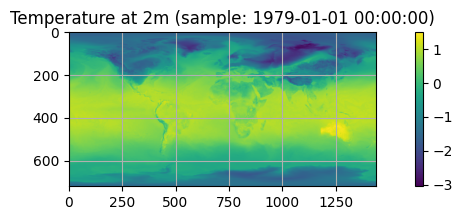

In [7]:
from modulus.datapipes.climate.era5_hdf5_new import ERA5HDF5Datapipe
datapipe = ERA5HDF5Datapipe(
    base_path="/iopsstor/scratch/cscs/stefschu/DSM500/data/FCN_ERA5_data_v0",
    data_folder="train",
    shuffle=False,
)

data = next(iter(datapipe))

input = data[0]["input"]
input_ts = data[0]["input_timestamps"]
output = data[0]["output"]

sample_image = input[0, 0, 2]
sample_resolution = sample_image.shape

plt.figure(figsize=(10, 2))
im = plt.imshow(sample_image)
plt.grid(True)
plt.colorbar(im)
from datetime import datetime
plt.title(f"Temperature at 2m (sample: {datetime.fromtimestamp(input_ts.item())})")
plt.show()

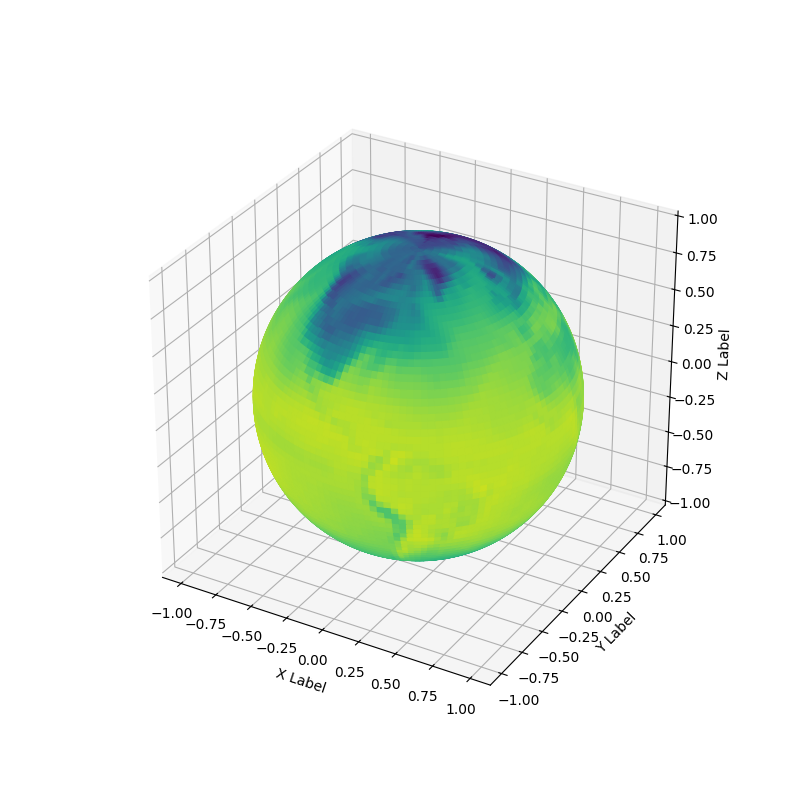

In [8]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize

def plot_globe(texture_img, point=None, scale=1.0, draw_pleuso_axes=False):
    img = texture_img

    # Reduce image resolution
    img = resize(img, (img.shape[0]//scale, img.shape[1]//scale), anti_aliasing=True)

    # Normalize
    img = (img - img.min()) / (img.max() - img.min())

    # Make RGB
    cmap = plt.get_cmap("viridis")
    img = cmap(img)[:, :, :3]

    if draw_pleuso_axes:
        mid_y = img.shape[0] // 2
        mid_x = img.shape[1] // 2
        img[mid_y, :] = 0
        img[:, mid_x] = 0

    # Flip image upside down
    img = np.flipud(img)

    # Image dimensions
    latitudes, longitudes = img.shape[:2]

    # Generate correct sphere mesh grid
    phi = np.linspace(-np.pi/2, np.pi/2, latitudes)
    theta = np.linspace(-np.pi, np.pi, longitudes)
    phi, theta = np.meshgrid(phi, theta, indexing="ij")

    # Convert spherical coordinates to Cartesian
    r = 0.99  # Sphere radius
    x = r * np.cos(phi) * np.cos(theta)
    y = r * np.cos(phi) * np.sin(theta)
    z = r * np.sin(phi)

    # Create figure and 3D axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=img, shade=False)

    ax.set_aspect('equal')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

plot_globe(texture_img=sample_image, scale=10.0)

## Graph

In [9]:
# Old graph
from modulus.utils.graphcast.graph import Graph

g = Graph(lat_lon_grid=map_grid_to_latlon)
g2m = g.create_g2m_graph()
m2g = g.create_m2g_graph()
m2m = g.create_mesh_graph()

g2m graph: Graph(num_nodes={'grid': 1038240, 'mesh': 40962},
      num_edges={('grid', 'g2m', 'mesh'): 1618816},
      metagraph=[('grid', 'mesh', 'g2m')])
m2g graph: Graph(num_nodes={'grid': 1038240, 'mesh': 40962},
      num_edges={('mesh', 'm2g', 'grid'): 3114720},
      metagraph=[('mesh', 'grid', 'm2g')])
mesh graph: Graph(num_nodes=40962, num_edges=327660,
      ndata_schemes={'x': Scheme(shape=(3,), dtype=torch.float32), 'lat_lon': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'x': Scheme(shape=(4,), dtype=torch.float32)})


In [10]:
from modulus.utils_new.graphcast.graph import Graph

g = model.graph
g2m = g.create_g2m_graph()
m2g = g.create_m2g_graph()
m2m = g.create_m2m_graph()

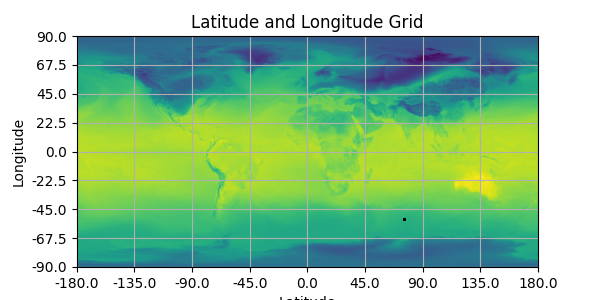

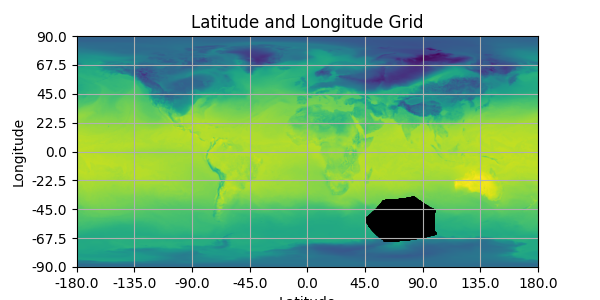

In [11]:
import matplotlib.ticker as ticker
from skimage.transform import resize

def plot_image(img, points_latlon=None, scale=1):
    img = resize(img, (img.shape[0]//scale, img.shape[1]//scale), anti_aliasing=True)
    img_height, img_width = img.shape

    num_ticks = 9
    _latitudes_positions = torch.linspace(0, img_height-1, steps=num_ticks, dtype=torch.int)
    _latitudes_labels = np.round(torch.linspace(90, -90, steps=num_ticks), 2).tolist()
    _longitudes_positions = torch.linspace(0, img_width-1, steps=num_ticks, dtype=torch.int)
    _longitudes_labels = np.round(torch.linspace(-180, 180, steps=num_ticks), 2).tolist()

    plt.figure(figsize=(6, 3))
    im = plt.imshow(img)
    if points_latlon is not None:
        points_on_grid = np.column_stack([
            np.interp(points_latlon[:, 0], [-90, 90], [0, img_height-1]),
            np.interp(points_latlon[:, 1], [-180, 180], [0, img_width - 1])
        ])
        plt.scatter(points_on_grid[:, 1]//scale, points_on_grid[:, 0]//scale, c="black", marker='o', s=1)
    plt.title('Latitude and Longitude Grid')
    plt.ylabel('Longitude')
    plt.xticks(_longitudes_positions, _longitudes_labels)
    plt.xlabel('Latitude')
    plt.yticks(_latitudes_positions, _latitudes_labels)
    plt.grid(True)
    plt.show()

_g = model.m2g_graph
src, dst = _g.edges()

random_idx = np.random.choice(np.unique(src))
random_mask = src == random_idx

src_selected = src[random_mask]
dst_selected = dst[random_mask]

src_latlon = _g.srcdata["lat_lon"][src_selected]
dst_latlon = _g.dstdata["lat_lon"][dst_selected]

# print(f"{random_idx=}")
# print(f"{len(_g.srcdata['lat_lon'])} -> {len(_g.dstdata['lat_lon'])}")
# print(f"{len(src_selected)} -> {len(dst_selected)}")
# print(f"{src_selected=} -> {src_latlon=}, {dst_selected=} -> {dst_latlon=}")


plot_image(sample_image, points_latlon=src_latlon)
plot_image(sample_image, points_latlon=dst_latlon)

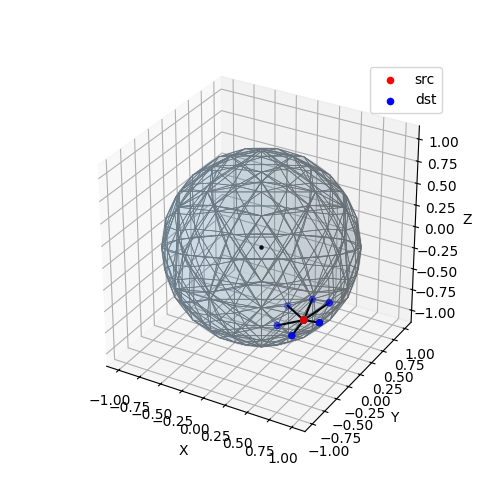

In [12]:
%matplotlib widget

def plot_icosahedron(vertices: torch.Tensor, faces: torch.Tensor, src_coords, dst_coords):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot sphere
    u, v = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, alpha=.1, edgecolor='none')
    ax.scatter(0, 0, 0, c='black', marker='o', s=5) # center

    # Plot base icosahedron vertices
    x, y, z = vertices.T
    # Plot base icosahedron faces
    for face in faces:
        _face = np.concatenate([face, face[:1]])
        x, y, z = vertices[_face].T
        ax.plot3D(x, y, z, color='gray', linewidth=0.5)

    # Plot src and dst coordinates
    x, y, z = src_coords.T
    ax.scatter(x, y, z, c='red', marker='o', label='src')
    x, y, z = dst_coords.T
    ax.scatter(x, y, z, c='blue', marker='o', label='dst')

    # Plot edges
    for src, dst in zip(src_coords, dst_coords):
        x, y, z = torch.stack([src, dst]).T
        ax.plot(x, y, z, c='black', linewidth=1.5)

    # Plot finishing
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    ax.legend()
    plt.show()

_g = model.m2m_graph
src, dst = _g.edges()

random_idx = np.random.choice(np.unique(src))
random_mask = src == random_idx

src_selected = src[random_mask]
dst_selected = dst[random_mask]

plot_icosahedron(
    vertices=model.graph.vertices,
    faces=model.graph.faces,
    src_coords=model.graph.vertices[src_selected],
    dst_coords=model.graph.vertices[dst_selected]
)

## Model

In [43]:
# New graph
from modulus.models_new.graphcast import GraphCastNet

model = GraphCastNet(
    sample_resolution=sample_resolution,
    grid_input_dimension=31,
    grid_output_dimension=21,
    mesh_level=2
)

map_grid_to_latlon, list_grid_latlon, list_grid_3D_coords, map_grid_3D_coords = model._build_coordinates()

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/models_new/module.py:12: UserWarning: Not yet implemented
  warnings.warn(f"Not yet implemented")


0 GraphCastNet initialization ...
[CACHE] Checking if 'meshes' is cached.
[CACHE] -> HIT! '/iopsstor/scratch/cscs/stefschu/DSM500/cache/icosahedron_meshes.pickled' exists.
[CACHE] Loading cache for 'meshes'.
[CACHE] -> Checking guard 'MeshesCacheGuard'.
0 GraphCastNet initialization done


In [ ]:
model.m2m_graph.edata["displacement_info"].shape, model.m2m_graph.edata["displacement_info"]

(torch.Size([1260, 4]),
 tensor([[-5.2573e-01, -8.0902e-01, -2.6287e-01,  1.0000e+00],
         [-5.2573e-01,  8.0902e-01, -2.6287e-01,  1.0000e+00],
         [-5.2573e-01,  7.1542e-10,  8.5065e-01,  1.0000e+00],
         ...,
         [-3.8753e-02, -2.5631e-01, -8.0716e-02,  2.7150e-01],
         [-5.0203e-02,  2.4863e-01, -1.7651e-01,  3.0902e-01],
         [-5.0203e-02,  2.7951e-01,  1.2184e-01,  3.0902e-01]]))

Process SpawnProcess-4:
Process SpawnProcess-1:
Process SpawnProcess-3:
Process SpawnProcess-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_task()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 434, in get_task
    scheduled_meta = self.task_receiver.get_task()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 13

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/models_new/module.py:12: UserWarning: Not yet implemented
  warnings.warn(f"Not yet implemented")


0 GraphCastNet initialization ...
[CACHE] Checking if 'meshes' is cached.
[CACHE] -> HIT! '/iopsstor/scratch/cscs/stefschu/DSM500/cache/icosahedron_meshes.pickled' exists.
[CACHE] Loading cache for 'meshes'.
[CACHE] -> Checking guard 'MeshesCacheGuard'.
old tensor([  0,   0,   0,  ..., 161, 161, 161], dtype=torch.int32) tensor([  1,   2,   4,  ..., 112, 159, 160], dtype=torch.int32)
old tensor([4.1888, 6.2832, 5.2360,  ..., 3.3176, 3.8822, 3.9179]) tensor([0.9184, 0.9184, 5.3647,  ..., 0.4089, 0.5134, 0.1887])
new tensor([  0,   0,   0,  ..., 161, 161, 161], dtype=torch.int32) tensor([  1,   2,   4,  ..., 112, 159, 160], dtype=torch.int32)
new tensor([4.1888, 6.2832, 5.2360,  ..., 3.3176, 3.8822, 3.9179]) tensor([0.9184, 0.9184, 5.3647,  ..., 0.4089, 0.5134, 0.1887])
old tensor([      0,       0,       0,  ..., 1038239, 1038239, 1038239],
       dtype=torch.int32) tensor([ 88,  89,  86,  ..., 118, 121, 122], dtype=torch.int32)
old tensor([6.2832, 4.1888, 2.0944,  ..., 5.2360, 1.0472, 3

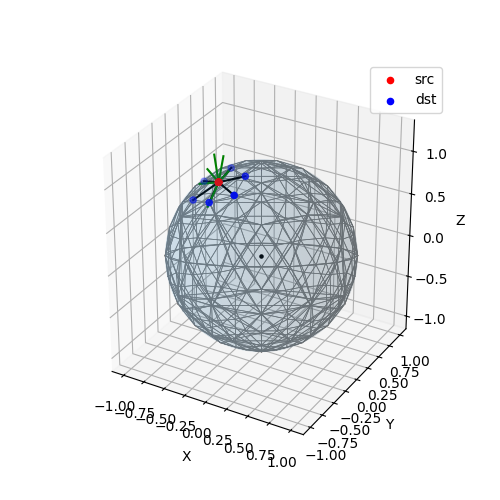

In [40]:
%matplotlib widget

def plot_icosahedron(vertices: torch.Tensor, faces: torch.Tensor, src_coords, dst_coords, edge_x, edge_displacement):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot sphere
    u, v = np.linspace(0, 2 * np.pi, 100), np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, alpha=.1, edgecolor='none')
    ax.scatter(0, 0, 0, c='black', marker='o', s=5) # center

    # Plot base icosahedron vertices
    x, y, z = vertices.T
    # Plot base icosahedron faces
    for face in faces:
        _face = np.concatenate([face, face[:1]])
        x, y, z = vertices[_face].T
        ax.plot3D(x, y, z, color='gray', linewidth=0.5)

    # Plot src and dst coordinates
    x, y, z = src_coords.T
    ax.scatter(x, y, z, c='red', marker='o', label='src')
    x, y, z = dst_coords.T
    ax.scatter(x, y, z, c='blue', marker='o', label='dst')

    # Plot edges
    for src, dst in zip(src_coords, dst_coords):
        x, y, z = torch.stack([src, dst]).T
        ax.plot(x, y, z, c='black', linewidth=1.5)

    # Plot x
    source_point = src_coords
    displaced_point = source_point + edge_x[:, :3]
    for src, dst in zip(source_point, displaced_point):
        x, y, z = torch.stack([src, dst]).T
        ax.plot(x, y, z, c='green', linewidth=1.5)

    # Plot edge_displacement
    source_point = src_coords
    displaced_point = source_point + edge_displacement[:, :3]
    #displaced_point = edge_displacement[:, :3]
    for src, dst in zip(source_point, displaced_point):
        x, y, z = torch.stack([src, dst]).T
        #ax.plot(x, y, z, c='yellow', linewidth=1.5)
    
    # Plot finishing
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    ax.legend()
    plt.show()

# ==================================================

# New graph
from modulus.models_new.graphcast import GraphCastNet

model = GraphCastNet(
    sample_resolution=sample_resolution,
    grid_input_dimension=31,
    grid_output_dimension=21,
    mesh_level=2
)

_g = model.m2m_graph
src, dst = _g.edges()

random_idx = np.random.choice(np.unique(src))
random_mask = src == random_idx

src_selected = src[random_mask]
dst_selected = dst[random_mask]

plot_icosahedron(
    vertices=model.graph.vertices,
    faces=model.graph.faces,
    src_coords=model.graph.vertices[src_selected],
    dst_coords=model.graph.vertices[dst_selected],
    edge_x=model.m2m_graph.edata["x"][random_mask],
    edge_displacement=model.m2m_graph.edata["displacement_info"][random_mask]
)